In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/README.md
/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/forbidden_words.txt
/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/dataset/train2.tsv
/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/dataset/val2.tsv
/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/dataset/test2.tsv
/kaggle/input/liarplus/LIAR-PLUS-master/README.md
/kaggle/input/liarplus/LIAR-PLUS-master/forbidden_words.txt
/kaggle/input/liarplus/LIAR-PLUS-master/dataset/train2.tsv
/kaggle/input/liarplus/LIAR-PLUS-master/dataset/val2.tsv
/kaggle/input/liarplus/LIAR-PLUS-master/dataset/test2.tsv


In [2]:
train = pd.read_csv('/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/dataset/train2.tsv',delimiter='\t',encoding='utf-8')
train.columns = ['values','id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue','extracted_justification']

valid = pd.read_csv('/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/dataset/val2.tsv',delimiter='\t',encoding='utf-8')
valid.columns = ['values','id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue','extracted_justification']

test = pd.read_csv('/kaggle/input/liarplus/liar-plus-master/LIAR-PLUS-master/dataset/test2.tsv',delimiter='\t',encoding='utf-8')
test.columns = ['values','id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue','extracted_justification']

train['news'] = train['statement'] + ' ' + train['extracted_justification']
valid['news'] = valid['statement'] + ' ' + valid['extracted_justification']
test['news'] = test['statement'] + ' ' + test['extracted_justification']


train = train.append(valid)

train_true = train[train['label']=='true']
train_false = train[train['label']=='false'] 

test_true = test[test['label']=='true'] 
test_false = test[test['label']=='false'] 


train = train_true.append(train_false)
test = test_true.append(test_false)

train_news = train['news']
train_label = train['label']

test_news = test['news'] 
test_label = test['label'] 


col_names = ['labels','text']
df_trn = pd.DataFrame({'text':train_news, 'labels':train_label}, columns=col_names)
df_val = pd.DataFrame({'text':test_news, 'labels':test_label}, columns=col_names)

In [3]:
df_trn = df_trn.sample(frac=1)
df_val = df_val.sample(frac=1)

In [4]:
positive_counts = len(df_trn[df_trn['labels']=='true'])
negative_counts = len(df_trn[df_trn['labels']=='false'])

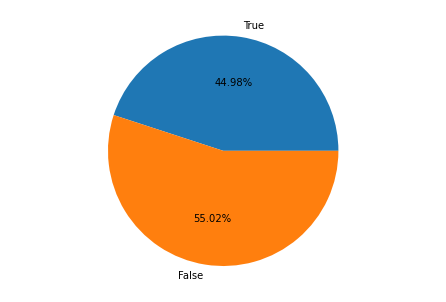

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['True', 'False']
nums = [positive_counts,negative_counts]
ax.pie(nums, labels = labels,autopct='%1.2f%%')
plt.show()

In [6]:
print("Total positive counts are: ",positive_counts)
print("Total negative counts are: ",negative_counts)

Total positive counts are:  1845
Total negative counts are:  2257


In [7]:
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

true_news = df_trn[df_trn['labels']=='true']
false_news = df_trn[df_trn['labels']=='false']

true_text = true_news['text'].values
false_text = false_news['text'].values

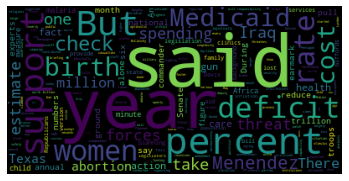

In [8]:
wordcloud = WordCloud().generate(str(true_text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

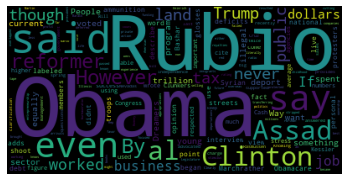

In [9]:
wordcloud = WordCloud().generate(str(false_text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data import Field,BucketIterator,TabularDataset
import torchtext
import spacy
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",'i\'m':'i am', "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled'}

In [12]:
def clean_contractions(text, mapping):
    text = text.lower()
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else mapping[t.lower()] if t.lower() in mapping else t for t in text.split(" ")])
    return text

In [13]:
def remove_newlines(sent):
    sent = re.sub(r'\s+', " ", sent )
    return sent

In [14]:
def convert_to_numerical(text):
    if text.lower() == 'false':
        return 0
    else:
        return 1

In [15]:
df_trn['text'] = df_trn['text'].apply(lambda x: clean_contractions(str(x),contraction_mapping))
df_val['text'] = df_val['text'].apply(lambda x: clean_contractions(str(x),contraction_mapping))

df_trn['text'] = df_trn['text'].apply(lambda x: remove_newlines(str(x)))
df_val['text'] = df_val['text'].apply(lambda x: remove_newlines(str(x)))


df_trn['labels'] = df_trn['labels'].apply(lambda x: convert_to_numerical(str(x)))
df_val['labels'] = df_val['labels'].apply(lambda x: convert_to_numerical(str(x)))

In [16]:
df_trn.to_csv('train.csv',index = False)
df_val.to_csv('validation.csv',index = False)

In [17]:
from torchtext import data

tokenizer = lambda s: s.lower().split()

text1 = data.Field(tokenize=tokenizer,
                  batch_first=True,
                  include_lengths=True,
                  )

label = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

In [18]:
fields = [('labels',label),('text',text1)]

In [19]:
train_data, valid_data = data.TabularDataset.splits(
    path='/kaggle/working/',
    train='train.csv',
    validation = 'validation.csv',
    format='csv',
    fields=fields,
    skip_header=True
)

In [20]:
text1.build_vocab(train_data,valid_data)

In [21]:
label.build_vocab(train_data,valid_data)

In [22]:
!cp ../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt /kaggle/working 

In [23]:
from torchtext import vocab

embeddings = vocab.Vectors('glove.6B.100d.txt','/kaggle/working')

100%|█████████▉| 399999/400000 [00:23<00:00, 17277.05it/s]


In [24]:
text1.build_vocab(train_data,valid_data,vectors = embeddings)
label.build_vocab()

In [25]:
train_itr,valid_itr = data.BucketIterator.splits((train_data,valid_data),
                                                          batch_size = 32,
                                                          sort_key = lambda x: len(x.text),
                                                          sort_within_batch = True,
                                                          device = device
                                                          )

In [26]:
def create_embedding_matrix(field,embeddings):  
    embedding_matrix = np.random.rand(len(field.vocab.stoi),100)
    for string,index in field.vocab.stoi.items():
        if not  all(x == 0 for x in embeddings[string].tolist()):
            embedding_matrix[index] = embeddings[string] 
    return embedding_matrix

In [27]:
embedding = create_embedding_matrix(text1,embeddings)

In [96]:
class Model(nn.Module):
    def __init__(self,num_layers,pad_index,batch_size,vocab_size,embedding_matrix,embedding_dimensions,hidden_size,bidirectional):
        super().__init__()
        self.embedding_dimensions = embedding_dimensions
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.embedding_layer = nn.Embedding(vocab_size,self.embedding_dimensions,padding_idx = pad_index)
        self.embedding_layer.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding_layer.weight.requires_grad = False
        self.lstm_layer = nn.LSTM(embedding_dimensions,hidden_size,bidirectional = self.bidirectional,num_layers = self.num_layers,batch_first = True)
        self.linear_layer_1 = nn.Linear(2*hidden_size,hidden_size)
        self.linear_layer_2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,1)
        
        
    def forward(self,x):
        embedding_outputs = self.embedding_layer(x)  
        h_n_1,c_n_1 = self.__init__hidden()
        
        h_n_1 = h_n_1.view(4,self.batch_size,self.hidden_size)
        c_n_1 = c_n_1.view(4,self.batch_size,self.hidden_size)
        
        output,(h_n_1,c_n_1) = self.lstm_layer(embedding_outputs,(h_n_1,c_n_1))
        output = output[:,-1,:]
        
        linear_output_1 = nn.ReLU()(self.linear_layer_1(output))
        linear_output_2 = nn.ReLU()(self.linear_layer_2(linear_output_1))
        final_output = self.output_layer(linear_output_2)
        
        return final_output
    
    def __init__hidden(self):
        return torch.zeros(self.batch_size,2*self.num_layers,self.hidden_size,dtype=torch.float32,device=device),torch.zeros(self.batch_size,2*self.num_layers,self.hidden_size,dtype=torch.float32,device=device) 

In [107]:
model = Model(pad_index = text1.vocab.stoi[text1.pad_token],
              batch_size = 32,
              vocab_size = len(text1.vocab),
              embedding_matrix = embedding,
              embedding_dimensions = 100,
              hidden_size = 256,
              bidirectional = True,
              num_layers = 2
             )

model = model.to(device = device)

In [103]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.03
optimizer = torch.optim.RMSprop(model.parameters(),lr = learning_rate) 
epochs = 30

In [104]:
def return_accuracy(logits,label):
    sigmoid = nn.Sigmoid()(logits)
    predictions = torch.round(sigmoid)
    predictions = predictions.view(32)
    return (predictions == label).sum().float()/float(label.size(0))

In [108]:
def train(epochs,criterion,optimizer,model,train_iterator,valid_iterator):
    train_losses = [] 
    valid_losses = []
    
    for epoch in range(epochs):
        print("Epoch {} out of {}".format(epoch,epochs))
        
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        
        epoch_valid_loss = 0
        epoch_valid_accuracy = 0
        
        for batch in train_iterator:
            model.train()
            optimizer.zero_grad()
            
            text = batch.text[0]
            label = batch.labels
            
            if text.size()[0] != 32:
                continue
            
            text.to(device)
            label.to(device)

            label = torch.tensor(label,dtype= torch.float32,device = device)
            
            predictions = model(text)
            loss = criterion(predictions,label.unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            
            batch_loss = loss.item()/len(batch)
            batch_accuracy = return_accuracy(predictions,label)
            
            epoch_train_loss += loss.item()
            epoch_train_accuracy += batch_accuracy.item()
            
        print("-"*80)
            
        print("Epoch Train Accuracy: ",epoch_train_accuracy/len(train_iterator))
        print("Epoch Train Loss: ",epoch_train_loss/len(train_iterator))
        train_losses.append(epoch_train_loss/len(train_iterator))
        print("-"*80)
    
        for batch_v in valid_iterator:
            model.eval()
            
            text_v = batch.text[0]
            label_v = batch.labels
            
            if text_v.size()[0] != 32:
                continue
    
            text_v.to(device)
            label_v.to(device)

            label_v = torch.tensor(label_v,dtype= torch.float32,device = device)
            
            predictions_v= model(text_v)
            loss_v = criterion(predictions_v,label_v.unsqueeze(1))
            
            batch_loss_v = loss_v.item()/len(batch_v)
            batch_accuracy_v = return_accuracy(predictions_v,label_v)
            
            epoch_valid_loss += loss_v.item()
            epoch_valid_accuracy += batch_accuracy_v.item()
            
        print("--"*60)
        print("Epoch valid Accuracy: ",epoch_valid_accuracy/len(valid_iterator))
        print("Epoch valid Loss: ",epoch_valid_loss/len(valid_iterator))
        print("--"*60)
        valid_losses.append(epoch_valid_loss/len(valid_iterator))
        
    return train_losses,valid_losses

In [109]:
train_loss,valid_loss = train(epochs,criterion,optimizer,model,train_itr,valid_itr)

Epoch 0 out of 30


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.5462693798449613
Epoch Train Loss:  0.6876023610432943
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.65625
Epoch valid Loss:  0.6925191879272461
------------------------------------------------------------------------------------------------------------------------
Epoch 1 out of 30


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.5453003875968992
Epoch Train Loss:  0.6876094327416531
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.65625
Epoch valid Loss:  0.6926308870315552
------------------------------------------------------------------------------------------------------------------------
Epoch 2 out of 30
--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.5486918604651163
Epoch Train Loss:  0.6875955346942872
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.65625
Epoch valid Loss:  0.69250828027725

--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.5472383720930233
Epoch Train Loss:  0.6876028069230014
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.5
Epoch valid Loss:  0.6931306719779968
------------------------------------------------------------------------------------------------------------------------
Epoch 17 out of 30
--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.5450581395348837
Epoch Train Loss:  0.6876119546187941
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.46875
Epoch valid Loss:  0.6932313442230225


In [110]:
def plot_losses(train_losses,valid_losses):
    epochs = range(len(train_losses))
    plt.plot(epochs,train_losses)
    plt.plot(epochs,valid_losses)
    plt.show()

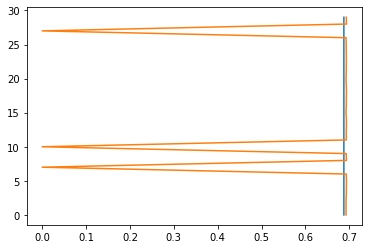

In [111]:
plot_losses(train_loss,valid_loss)